In [36]:
import pandas as pd
import datetime
import math
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [37]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader('AAPL', 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-06,118.160004,116.470001,116.779999,117.910004,31751900.0,112.973305
2017-01-09,119.430000,117.940002,117.949997,118.989998,33561900.0,114.008080
2017-01-10,119.379997,118.300003,118.769997,119.110001,24462100.0,114.123047
2017-01-11,119.930000,118.599998,118.739998,119.750000,27588600.0,114.736275
2017-01-12,119.300003,118.209999,118.900002,119.250000,27086200.0,114.257195


In [47]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail(20)

Date
2016-12-14    105.688912
2016-12-15    105.882091
2016-12-16    106.017166
2016-12-19    106.145482
2016-12-20    106.278000
2016-12-21    106.394127
2016-12-22    106.517762
2016-12-23    106.631180
2016-12-27    106.745493
2016-12-28    106.839668
2016-12-29    106.925071
2016-12-30    106.997562
2017-01-03    107.080935
2017-01-04    107.163730
2017-01-05    107.249795
2017-01-06    107.335924
2017-01-09    107.433354
2017-01-10    107.533458
2017-01-11    107.641030
2017-01-12    107.741141
Name: Adj Close, dtype: float64

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

Text(0, 0.5, 'Value')

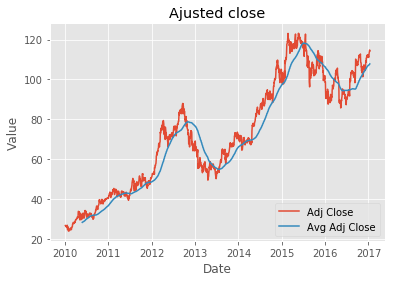

In [69]:
plt.plot(df['Adj Close'])
plt.plot(mavg)
plt.legend(('Adj Close', 'Avg Adj Close'),
           loc='lower right')
plt.title('Ajusted close')
plt.xlabel('Date')
plt.ylabel('Value')

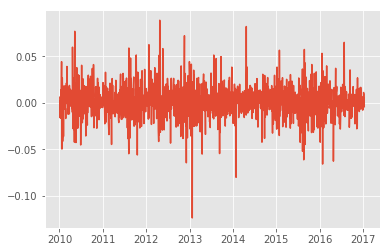

In [67]:
rets = close_px / close_px.shift(1) - 1
plt.plot(rets)
plt.title('Return deviation')
plt.xlabel('Date')
plt.ylabel('Value')

In [70]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'], 'yahoo', start=start, end=end)['Adj Close']

In [72]:
dfcomp.head()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2010-01-04,26.681330,10.769575,312.204773,98.142967,24.443624
2010-01-05,26.727465,10.825342,310.829926,96.957375,24.451517
2010-01-06,26.302330,10.769575,302.994293,96.327530,24.301458
2010-01-07,26.253704,11.327226,295.940735,95.994110,24.048725
2010-01-08,26.428249,11.571195,299.885956,96.957375,24.214581


In [74]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

In [76]:
corr.head()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.381475,0.411708,0.383816,0.393525
GE,0.381475,1.000000,0.422261,0.535149,0.474112
GOOG,0.411708,0.422261,1.000000,0.403004,0.472081
IBM,0.383816,0.535149,0.403004,1.000000,0.496582
MSFT,0.393525,0.474112,0.472081,0.496582,1.000000


Text(0, 0.5, 'Returns GE')

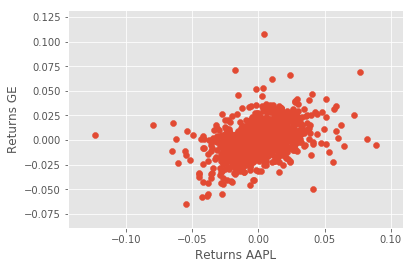

In [78]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

/home/apolanco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


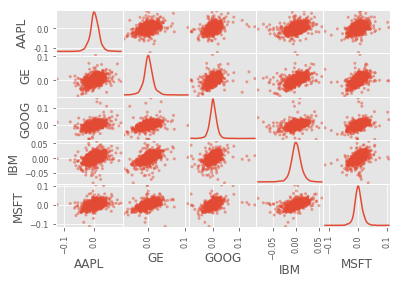

In [79]:
pd.scatter_matrix(retscomp, diagonal='kde')
figsize=(10, 10);

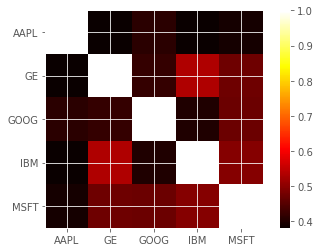

In [80]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

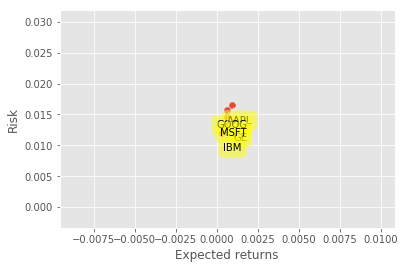

In [84]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x , y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(label, xy=(x, y), xytext=(20, -20), 
                  textcoords='offset points', 
                  ha='right', va='bottom', 
                  bbox=dict(boxstyle='round, pad=0.5',fc='yellow', alpha=0.5),
                  arrowprops = dict(arrowstyle='->',  connectionstyle='arc3,rad=0'))

In [89]:
# feature engineering
dfreg = df.loc[:,['Adj Close']]
dfreg['HL_PTC'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PTC_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [90]:
dfreg.head()

,Adj Close,HL_PTC,PTC_change
Date,,,
2010-01-04,26.681330,0.990606,0.271752
2010-01-05,26.727465,1.091520,-0.102519
2010-01-06,26.302330,2.123523,-1.590633
2010-01-07,26.253704,1.400893,-0.552538
2010-01-08,26.428249,1.386924,0.798864


In [91]:
# data cleaning
# drop missing values - separating the label we want to predict - scale data - split train and test
dfreg.fillna(value=-99999, inplace=True)

In [94]:
# we want to separate 1 percent of the ddata to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

In [95]:
# separate y label
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [96]:
# scale the X so that everyone can have the same distributio for linear regression
from sklearn import preprocessing
X = preprocessing.scale(X)

In [97]:
# finally we want to find the data series of late X and early x 
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

In [101]:
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [102]:
from sklearn import model_selection

trainX, testX, trainY, testY = model_selection.train_test_split(X, y, test_size=0.2)

In [98]:
# model generation
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [103]:
# linear regression 
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(trainX, trainY)

# quadratic regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(trainX, trainY)

# quadratic regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(trainX, trainY)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(trainX, trainY)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [105]:
confidence_reg = clfreg.score(testX, testY)
confidence_poly2 = clfpoly2.score(testX, testY)
confidence_poly3 = clfpoly3.score(testX, testY)
confidence_knn = clfknn.score(testX, testY)

In [116]:
for i, element in enumerate(array):
    print('The classifier', array_str[i], 'is',  element)

The classifier confidence_reg is 0.968166595196813
The classifier confidence_poly2 is 0.965644758282812
The classifier confidence_poly3 is 0.8920742977272668
The classifier confidence_knn is 0.9384058154391277


In [110]:
print(str(array))

[0.968166595196813, 0.965644758282812, 0.8920742977272668, 0.9384058154391277]


In [118]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

In [119]:
forecast_set

array([111.31562621, 111.85331456, 112.22013433, 112.33691452,
       111.60357897, 111.79017085, 112.46184854, 111.99183108,
       112.01999137, 111.11441337, 111.40982385, 111.35253167,
       111.87185392, 113.03474599, 114.06616128, 114.2258673 ,
       114.79235953, 114.35636081])

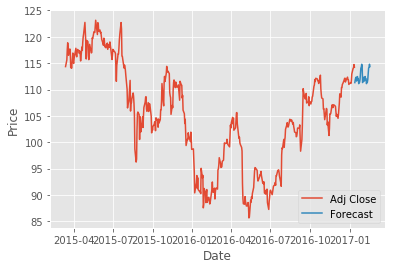

In [122]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

plt.plot(dfreg['Adj Close'].tail(500))
plt.plot(dfreg['Forecast'].tail(500))

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()